In [1]:
!git clone https://github.com/NGOVANMANH/DataMiningProject.git

Cloning into 'DataMiningProject'...
remote: Enumerating objects: 25040, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 25040 (delta 6), reused 21 (delta 5), pack-reused 25017
Receiving objects: 100% (25040/25040), 542.18 MiB | 17.55 MiB/s, done.
Resolving deltas: 100% (10/10), done.
Updating files: 100% (75009/75009), done.


## Importing Necessary Libraries

In [2]:
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from sklearn.model_selection import train_test_split

## Defining Constants

In [3]:
IMG_WIDTH = 224
IMG_HEIGHT = 224
BATCH = 32

## Setting the Paths to the Datasets

In [4]:
# Set the paths to the datasets
train_dir = '/content/DataMiningProject/dataset/train'
test_dir = '/content/DataMiningProject/dataset/test'

## Loading Pre-Trained MobileNet Model

In [5]:
# Load pre-trained MobileNet model + feature extractor
base_model = MobileNet(weights='imagenet', include_top=False, pooling='avg')
model = Model(inputs=base_model.input, outputs=base_model.output)

17225924/17225924 [==============================] - 0s 0us/step


## Function to Preprocess and Extract Features

In [6]:
# Function to preprocess and extract features from an image directory in batches
def extract_features_batch(directory, batch_size=BATCH, target_size=(IMG_WIDTH, IMG_HEIGHT)):
    features = []
    labels = []
    for label in os.listdir(directory):
        label_dir = os.path.join(directory, label)
        image_paths = [os.path.join(label_dir, image_path) for image_path in os.listdir(label_dir)]
        num_images = len(image_paths)
        for i in range(0, num_images, batch_size):
            batch_paths = image_paths[i:i+batch_size]
            batch_images = []
            for image_path in batch_paths:
                img = load_img(image_path, target_size=target_size)
                img_array = img_to_array(img)
                img_array = preprocess_input(img_array)
                batch_images.append(img_array)
            batch_images = np.array(batch_images)
            batch_features = model.predict(batch_images)
            features.extend(batch_features)
            labels.extend([label] * len(batch_features))
    return np.array(features), np.array(labels)

## Extracting Features and Labels

In [7]:
# Extract features and labels from train and test sets
train_features, train_labels = extract_features_batch(train_dir)
test_features, test_labels = extract_features_batch(test_dir)

1/1 [==============================] - 0s 486ms/step


## Creating and Training the RandomForest Classifier

In [8]:
# Create and train the RandomForest classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(train_features, train_labels)

RandomForestClassifier(random_state=42)

In [9]:
# # Validate the classifier
# y_val_pred = clf.predict(X_val)
# val_accuracy = accuracy_score(y_val, y_val_pred)
# print(f'Validation Accuracy: {val_accuracy * 100:.2f}%')

## Testing the Classifier

In [10]:
# Test the classifier
y_test_pred = clf.predict(test_features)
test_accuracy = accuracy_score(test_labels, y_test_pred)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

Test Accuracy: 98.30%


## Plotting the Confusion Matrix

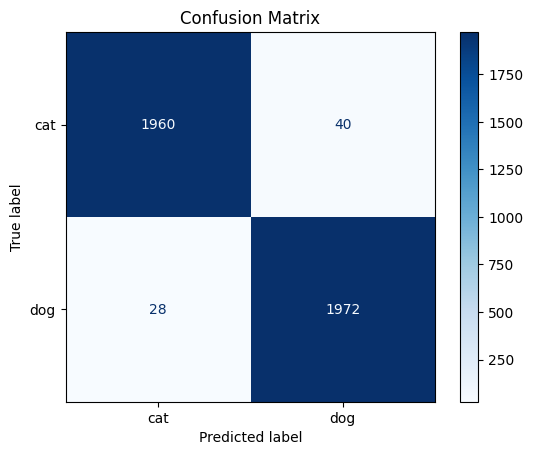

In [11]:
# Plot confusion matrix
conf_matrix = confusion_matrix(test_labels, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=clf.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

## Plotting Feature Importance

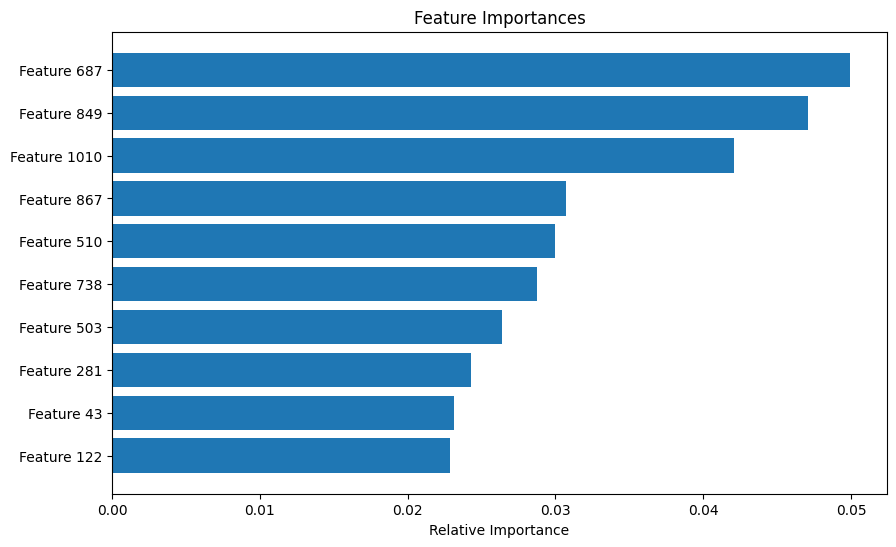

In [12]:
# Plot feature importance
importances = clf.feature_importances_
indices = np.argsort(importances)[-10:]  # Get indices of top 10 important features

plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.barh(range(len(indices)), importances[indices], align="center")
plt.yticks(range(len(indices)), [f"Feature {i}" for i in indices])
plt.xlabel("Relative Importance")
plt.show()

## Function to Predict Class and Max Score from an Image

In [13]:
# Function to predict the class and max score from an input image path
def predict_image(image_path):
    img = load_img(image_path, target_size=(IMG_WIDTH, IMG_HEIGHT))
    img_array = img_to_array(img)
    img_array = preprocess_input(img_array)
    img_array = np.expand_dims(img_array, axis=0)
    features = model.predict(img_array)

    # Predict the class
    prediction = clf.predict(features)
    # Predict probabilities for each class
    prediction_proba = clf.predict_proba(features)

    # Get the maximum score (confidence) for the predicted class
    max_score = np.max(prediction_proba)

    return prediction[0], max_score

In [21]:
# Example usage
image_path = '/content/DataMiningProject/samples/dog.jpg'
# image_path = '/content/Giong-Cho-2.jpg'
predicted_class, max_score = predict_image(image_path)
print(f'The predicted class for the image is: {predicted_class}')
print(f'The confidence score for the prediction is: {max_score*100:.2f}%')

1/1 [==============================] - 0s 202ms/step
The predicted class for the image is: dog
The confidence score for the prediction is: 61.00%


In [17]:
# Example usage
image_path = '/content/DataMiningProject/samples/cat.jpg'
predicted_class, max_score = predict_image(image_path)
print(f'The predicted class for the image is: {predicted_class}')
print(f'The confidence score for the prediction is: {max_score*100:.2f}%')

1/1 [==============================] - 0s 52ms/step
The predicted class for the image is: cat
The confidence score for the prediction is: 99.00%
